# USERS: Preprocessing

In [ ]:
# --- PARAMETER ---
topic = 'ks_cd'

In [1]:
# Load & extract text
import pandas as pd
tweets = pd.read_csv(f'{topic}_pre_sentiment_users.csv', dtype={"Author ID": str})
corpus = tweets['Content'].astype(str) #grab content col as list of strings
corpus

0                                        @Keir_Starmer 😡
1      @narendramodi @Keir_Starmer The potential of b...
2      @Keir_Starmer Another sound bite, and all talk...
3      @Keir_Starmer Surely you mean more jobs being ...
4      @TheGriftReport @Keir_Starmer @BritishUtdX Som...
                             ...                        
670    @BenInRushcliffe @10DowningStreet @LucyMPowell...
671    Listening to what has just been said they stil...
672    @narendramodi @Keir_Starmer Great to see India...
673    @Keir_Starmer I thought India was supposed to ...
674    @Keir_Starmer 1075 illegal migrants yesterday ...
Name: Content, Length: 675, dtype: object

In [2]:
# Basic Cleaning
import re

def clean_text(text):
    text = text.lower()                                 # lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", "", text) # remove urls
    text = re.sub(r"@\w+", "", text)                    # remove mentions
    text = re.sub(r"#\w+", "", text)                    # remove hashtags
    text = re.sub(r"\brt\b", "", text)                  # remove 'rt'
    text = re.sub(r"[^a-z\s]", "", text)                # keep only letters & spaces
    text = re.sub(r"\s+", " ", text).strip()            # remove extra whitespace
    return text

# Apply cleaning
corpus_clean = corpus.apply(clean_text)

corpus_clean.head(10)

0                                                     
1    the potential of blockchain to enhance supply ...
2    another sound bite and all talk the only thing...
3    surely you mean more jobs being outsourced to ...
4              someone where unpleasant thats for sure
5                           is knobbing or is knobbing
6    please take him to a deep spiritual cleansing ...
7    youre welcome to him dont bother sending him back
8    what happened to ispr havildars churan of isol...
9    i can access my own money without digital id s...
Name: Content, dtype: object

In [3]:
#import nltk
#nltk.download('punkt')
#nltk.download('punkt_tab')
#nltk.download('stopwords')
#nltk.download("wordnet")
#nltk.download("omw-1.4")

from nltk.tokenize import word_tokenize

In [4]:
# Tokenization
tokens = corpus_clean.apply(word_tokenize)
tokens

0                                                     []
1      [the, potential, of, blockchain, to, enhance, ...
2      [another, sound, bite, and, all, talk, the, on...
3      [surely, you, mean, more, jobs, being, outsour...
4         [someone, where, unpleasant, thats, for, sure]
                             ...                        
670    [have, you, ever, seen, in, action, i, have, s...
671    [listening, to, what, has, just, been, said, t...
672    [great, to, see, indiauk, ties, growing, stron...
673    [i, thought, india, was, supposed, to, be, san...
674    [illegal, migrants, yesterday, alone, good, da...
Name: Content, Length: 675, dtype: object

In [5]:
# Removing Stopwords
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))
corpus_nostop = corpus_clean.apply(
    lambda x: " ".join([word for word in x.split() if word not in stop_words])
)

In [6]:
# Stemming / Lemmatization
from nltk.stem import PorterStemmer, WordNetLemmatizer

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

#corpus_stemmed = corpus_clean.apply(
#    lambda x: " ".join([stemmer.stem(word) for word in x.split()])
#)

corpus_lemmatized = corpus_clean.apply(
    lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()])
)

In [7]:
# Organize
prep = pd.DataFrame({
    "original": corpus,
    "clean": corpus_clean,
    "tokens": tokens,
    "no_stop": corpus_nostop,
    #"stemmed": corpus_stemmed,
    "lemmatized": corpus_lemmatized
})

prep.head()

,original,clean,tokens,no_stop,lemmatized
0,@Keir_Starmer 😡,,[],,
1,@narendramodi @Keir_Starmer The potential of b...,the potential of blockchain to enhance supply ...,"[the, potential, of, blockchain, to, enhance, ...",potential blockchain enhance supply chain resi...,the potential of blockchain to enhance supply ...
2,"@Keir_Starmer Another sound bite, and all talk...",another sound bite and all talk the only thing...,"[another, sound, bite, and, all, talk, the, on...",another sound bite talk thing see cheap labour...,another sound bite and all talk the only thing...
3,@Keir_Starmer Surely you mean more jobs being ...,surely you mean more jobs being outsourced to ...,"[surely, you, mean, more, jobs, being, outsour...",surely mean jobs outsourced india amp indians ...,surely you mean more job being outsourced to i...
4,@TheGriftReport @Keir_Starmer @BritishUtdX Som...,someone where unpleasant thats for sure,"[someone, where, unpleasant, thats, for, sure]",someone unpleasant thats sure,someone where unpleasant thats for sure


# USERS: Sentiment Analysis

In [8]:
# RoBERTa Transformer Model
import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

texts = prep["lemmatized"].fillna("").tolist()

def roberta_predict(texts, batch_size=32, max_length=128):
    all_probs = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            enc = tokenizer(
                batch,
                padding=True,
                truncation=True,
                max_length=max_length,
                return_tensors="pt"
            )
            enc = {k: v.to(device) for k, v in enc.items()}
            logits = model(**enc).logits
            probs = torch.softmax(logits, dim=-1).cpu().numpy()  # (B, 3)
            all_probs.append(probs)
    return np.vstack(all_probs)

probs = roberta_predict(texts, batch_size=32, max_length=128)  # columns: [neg, neu, pos]

# Add columns to your dataframe
prep[["rob_neg","rob_neu","rob_pos"]] = probs

# A handy polarity score in [-1,1] (pos - neg)
prep["rob_score"] = prep["rob_pos"] - prep["rob_neg"]

# Discrete label
labels = np.array(["negative","neutral","positive"])
prep["rob_label"] = labels[probs.argmax(axis=1)]

prep[["original","rob_label","rob_score","rob_neg","rob_neu","rob_pos"]].head(10)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


,original,rob_label,rob_score,rob_neg,rob_neu,rob_pos
0,@Keir_Starmer 😡,positive,0.175723,0.225575,0.373126,0.401299
1,@narendramodi @Keir_Starmer The potential of b...,positive,0.791772,0.006050,0.196127,0.797823
2,"@Keir_Starmer Another sound bite, and all talk...",negative,-0.789468,0.803037,0.183395,0.013568
3,@Keir_Starmer Surely you mean more jobs being ...,negative,-0.849182,0.856973,0.135235,0.007791
4,@TheGriftReport @Keir_Starmer @BritishUtdX Som...,negative,-0.773025,0.788164,0.196698,0.015138
5,@LabourfutureUK Is @Keir_Starmer knobbing @GNe...,neutral,-0.160351,0.203120,0.754111,0.042769
6,@narendramodi @Keir_Starmer Please take him to...,neutral,0.133959,0.165191,0.535658,0.299151
7,@narendramodi @Keir_Starmer You’re welcome to ...,neutral,0.184766,0.130264,0.554706,0.315030
8,@Keir_Starmer @GongR1ght \n@mustafamasood0 \n\...,neutral,-0.315670,0.336032,0.643605,0.020363
9,@narendramodi @Keir_Starmer I can access my ow...,neutral,0.033956,0.103473,0.759097,0.137430


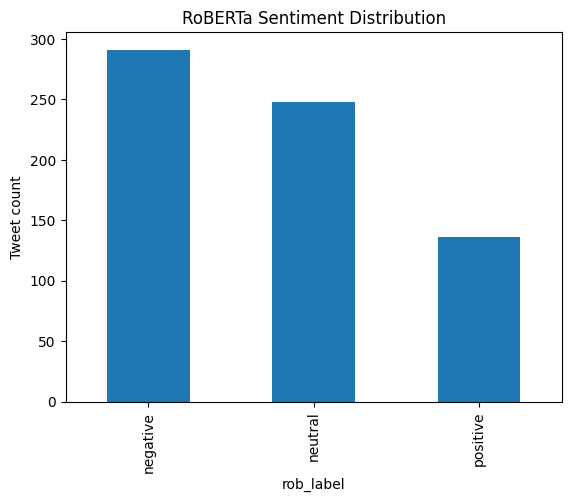

rob_label
negative    291
neutral     248
positive    136
Name: count, dtype: int64

In [9]:
# Distribution Plot
import matplotlib.pyplot as plt
prep["rob_label"].value_counts().reindex(["negative","neutral","positive"]).plot(kind="bar")
plt.title("RoBERTa Sentiment Distribution")
plt.ylabel("Tweet count")
plt.show()
prep["rob_label"].value_counts().reindex(["negative","neutral","positive"])

In [10]:
# Join Author ID with sentiment results
author_sentiment = tweets[["Author ID"]].join(prep["rob_label"])

# Filter out neutrals
author_sentiment = author_sentiment[author_sentiment["rob_label"] != "neutral"]

# Split into positive and negative
positive_users = author_sentiment[author_sentiment["rob_label"] == "positive"]
negative_users = author_sentiment[author_sentiment["rob_label"] == "negative"]

# Export
author_sentiment.to_csv(f'{topic}_cd_uid_labels.csv', index=False, header=False)
#positive_users.to_csv(f'{topic}_cd_uid_pos.csv', index=False, header=False)
#negative_users.to_csv(f'{topic}_cd_uid_neg.csv', index=False, header=False)

print(f'Exported {topic}_cd_uid_labels.csv')
#print(f'Exported {topic}_cd_uid_pos.csv and {topic}_cd_uid_neg.csv')
print(f'Original Tweets: {tweets.shape[0]}')
print(f'Negative Users: {negative_users.shape[0]}\nPositive Users: {positive_users.shape[0]}')

Exported keir_starmer_positive_users.csv and keir_starmer_negative_users.csv
Original Tweets: 675
Negative Users: 291
Positive Users: 136
